This is a text classification solution to classify text to 1,2,3,4 and 5 stars. The data for this work is gotten from kaggle, it is a yelps data and can be accessed from this link https://www.kaggle.com/competitions/yelp-recsys-2013/data

In [1]:
!python --version

Python 3.8.16


In [2]:
# Libraries to be used

# dataframe
import pandas as pd
import numpy as np

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

import transformers

# machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# metric
from sklearn.metrics import (precision_score, 
                             recall_score, 
                             f1_score,
                             accuracy_score,
                             precision_recall_curve,
                             roc_auc_score,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             classification_report)
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler


from tensorflow.keras import preprocessing as kp
from tensorflow.keras import models, layers, optimizers

from sklearn.feature_extraction.text import  TfidfTransformer

# time date library
from datetime import datetime

#
from tensorflow.keras.utils import to_categorical

In [3]:
# !pip install transformers
# !pip install -U scikit-learn
# !pip install nltk
# !pip install gensim

In [4]:
# Text processing
import re
import nltk
import gensim
import gensim.downloader as api
from gensim.utils import simple_preprocess

##### Functions for training and evaluation of model

In [5]:
# function to train a model and compute train accuracy

def train(model, X,y):
    """
    Function to train the model and compute accuracy
    
    model: Model algorithm not yet traineed
    X: train feaures
    y: train target
    """
    
    trained_model = model.fit(X,y)
    preds = trained_model.predict(X)
    acc = accuracy_score(y, preds)
    
    print(f'Trained Accuracy: {acc}')
    return trained_model

In [6]:
# read the csv file
# data was gotten from kaggle with the link "https://www.kaggle.com/competitions/yelp-recsys-2013/data"
data = pd.read_csv(r'yelp.csv')

In [7]:
# check the first 5 rows of the data
data.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [8]:
data['type'].unique()

array(['review'], dtype=object)

##### Observations from the columns

- Business_id, a form of key for individual business that gave review
- Date, date review where made
- Review_id, each review id act as a log id or request id
- text, comprises of the review sentences produced by individual business ID
- type, shows that it is a reiew
- User Id
- cool, useful, funny are further description towards the review ratings
- Stars, this is the rating from 1 through 5

- To check the content of the first row in the text column

In [9]:
data['text'][0]

'My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.\n\nDo yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I\'ve ever had.  I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.\n\nWhile EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I\'ve ever had.\n\nAnyway, I can\'t wait to go back!'

##### Observations
- from the didsplay above, we can observe that the text contains every expression in english language (word, quotation marks, comma, full-stops) this will be hard for the machine to intepret



##### Extracting the star and text into one dataframe

In [10]:
df = data[['text','stars']]

#display the first 5 rows
df.head()

,text,stars
0,My wife took me here on my birthday for breakf...,5
1,I have no idea why some people give bad review...,5
2,love the gyro plate. Rice is so good and I als...,4
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5
4,General Manager Scott Petello is a good egg!!!...,5


##### Analyze the data

In [11]:
print(f'Total number of reviews {len(df)}')
print(50*'-')
print('Split by stars:')
print(df['stars'].value_counts())
print(50*'-')
no_stars = len(df['stars'].unique())
print(f'Number of categories:{no_stars}')


Total number of reviews 10000
--------------------------------------------------
Split by stars:
4    3526
5    3337
3    1461
2     927
1     749
Name: stars, dtype: int64
--------------------------------------------------
Number of categories:5


##### Observations
- The data contains 10,000 reviews
- The company have high number of 4 star review
- Checking the number of reviews based on categories, I observed that from 3 stars upward the company had more reviews than in 1 and 2 stars
- The main goal of businesses is to make sure every customers are satisfied, by this the business will maximise profit

##### Data Pre-processing for BERT and RNN

- To do this we first convert to lower case and remove special characters
- convert from strings to lists of words (tokenize)
- Eliminate noise from the system by removing stop words 
- Having words with the same meaning identified as the same by remove words that contains -ing, -ly,...,like (Stemm)
- convert the word into a root word (Lemmaize)

In [12]:
# Reference: Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT from Medium

# using the stopwords list from nltk
st_stopwords = nltk.corpus.stopwords.words("english")

def preprocess_text(text, flg_stemm= False, flg_lemm=True, st_stopwords=None):
    # clean (convert to lower case and remove punctuations and characters and then strip)
    # The function is split into various steps for pedagogical purpose
    
    text = str(text).lower()
    text = text.strip()
    text = re.sub(r'[^\w\s]','', text)
    
    # Tokenize
    lst_text = text.split()
    
    # remove Stopwords
    if st_stopwords is not None:
        lst_text= [word for word in lst_text if word not in st_stopwords]
        
    # Stemming (remove -ing, -ly, ....)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
        
    # Lemmatisation(convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text =[lem.lemmatize(word) for word in lst_text]
        
    # back to string from list
    text = " ".join(lst_text)
    return text

In [13]:
# apply the function to the whole corpus
df['cleaned_text']= df['text'].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True, st_stopwords=st_stopwords))

# head
df.head()

,text,stars,cleaned_text
0,My wife took me here on my birthday for breakf...,5,wife took birthday breakfast excellent weather...
1,I have no idea why some people give bad review...,5,idea people give bad review place go show plea...
2,love the gyro plate. Rice is so good and I als...,4,love gyro plate rice good also dig candy selec...
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",5,rosie dakota love chaparral dog park convenien...
4,General Manager Scott Petello is a good egg!!!...,5,general manager scott petello good egg go deta...


In [14]:
# check
df['cleaned_text'][0]

'wife took birthday breakfast excellent weather perfect made sitting outside overlooking ground absolute pleasure waitress excellent food arrived quickly semibusy saturday morning looked like place fill pretty quickly earlier get better favor get bloody mary phenomenal simply best ive ever im pretty sure use ingredient garden blend fresh order amazing everything menu look excellent white truffle scrambled egg vegetable skillet tasty delicious came 2 piece griddled bread amazing absolutely made meal complete best toast ive ever anyway cant wait go back'

- The above makes the text more readable to machines

##### Splitting  into Train and Test data

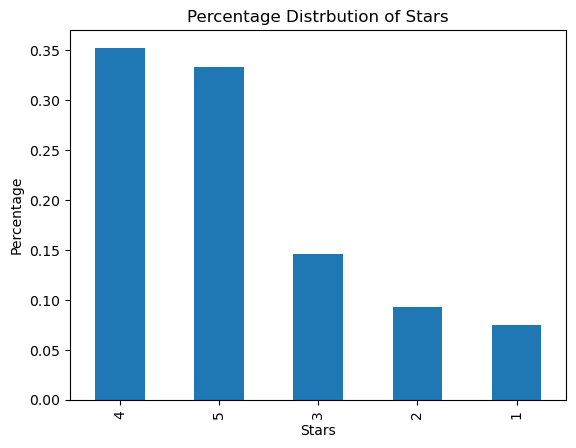

In [15]:
# check the proportion of the stars in the data
df['stars'].value_counts(normalize=True).plot(kind = 'bar')
plt.title("Percentage Distrbution of Stars")
plt.xlabel('Stars')
plt.ylabel('Percentage');


##### Observations
- The above shows the proportion of each stars in the data, and we can observe that 1 and 2 stars will not generate great result due to thier sizes in the data

In [16]:
df.columns

Index(['text', 'stars', 'cleaned_text'], dtype='object')

In [17]:
X = df['cleaned_text'] # input (independent variable)
y= df['stars'] # output (dependent variable)

In [18]:
# initialize the count vectorizer
cv = CountVectorizer()

In [19]:
# fit to X
X = cv.fit_transform(X)

In [20]:
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y) # 20% of the data will be for test data 

In [21]:
# default logistic regression model
log_reg = LogisticRegression(random_state=0)

In [22]:
# training the model
log_reg_model = train(log_reg,X_train, y_train) 

Trained Accuracy: 0.982


- With the training data the model have an accuracy of 98%

In [23]:
# log_reg.fit(X_train,y_train)

In [24]:
# the target is a multiclass, hence we want to view the performance of the model on all the classes
predictions = log_reg_model.predict(X_test)

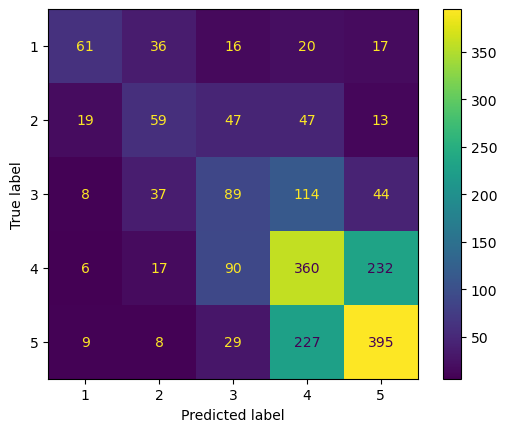



              precision    recall  f1-score   support

           1       0.59      0.41      0.48       150
           2       0.38      0.32      0.35       185
           3       0.33      0.30      0.32       292
           4       0.47      0.51      0.49       705
           5       0.56      0.59      0.58       668

    accuracy                           0.48      2000
   macro avg       0.47      0.43      0.44      2000
weighted avg       0.48      0.48      0.48      2000



In [25]:
conf = confusion_matrix(y_test,predictions)
disp = ConfusionMatrixDisplay(conf, display_labels=[1,2,3,4,5])
disp.plot()
plt.show()
print('\n')
print(classification_report(y_test,predictions))

##### Observations

Considering the 4 and 5 classes

- Precision: Out of the 701 of stars predicted to be 5 by the model only 395 (56%) were 5 stars.
- Recall: Out of all all the 718 5 stars the model correctly predicted 59% correctly
- The model is incorrectly predicting 232 to be 5 stars instead of 4 stars (False negative)
- The model is incorrectly predicting that 227 of the reviews where 4 stars instead of 5 stars (False Positive)

##### Term Frequency-Inverse Document Frequency model

In [26]:
X = df['cleaned_text'] # input (independent variable)
y= df['stars'] # output (dependent variable)
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y) # 20% of the data will be for test data 

In [27]:
corpus = X_train

# initialize the vectorizer
vector_tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

# fit the vectorizer to the training data
vector_tfidf.fit(corpus)


TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

##### Building the model

In [28]:
# initialize the model


tfidf_model = Pipeline([('vectorizer', vector_tfidf), ('classifier', log_reg)])

start_time = datetime.now()
tfidf_model.fit(X_train,y_train)
end_time = datetime.now()

training_time_tfidf = (end_time-start_time).total_seconds()

In [29]:
# train evaluation
pred_train_tfidf = tfidf_model.predict(X_train)
acc_train_tfidf = accuracy_score(y_train, pred_train_tfidf)
print(f'Accuracy Training data: {acc_train_tfidf}')

# test evaluation

pred_test_tfidf = tfidf_model.predict(X_test)
acc_test_tfidf = accuracy_score(y_test, pred_test_tfidf)
print(f'Accuracy of the Test data: {acc_test_tfidf}')

# Training Time
print(f'Training Time: {training_time_tfidf}')



Accuracy Training data: 0.798875
Accuracy of the Test data: 0.5165
Training Time: 4.281


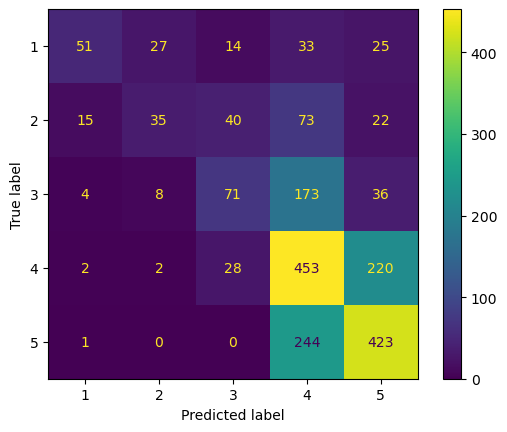



              precision    recall  f1-score   support

           1       0.70      0.34      0.46       150
           2       0.49      0.19      0.27       185
           3       0.46      0.24      0.32       292
           4       0.46      0.64      0.54       705
           5       0.58      0.63      0.61       668

    accuracy                           0.52      2000
   macro avg       0.54      0.41      0.44      2000
weighted avg       0.52      0.52      0.50      2000



In [30]:
conf = confusion_matrix(y_test,pred_test_tfidf)
disp = ConfusionMatrixDisplay(conf, display_labels=[1,2,3,4,5])
disp.plot()
plt.show()
print('\n')
print(classification_report(y_test,pred_test_tfidf))

##### Deep Learning - RNN

In [31]:
# y_dp_train = to_categorical(y_train)
# y_dp_test = to_categorical(y_test)

In [32]:
# Renaming, Input -> X, Output -> y
X_dp = df['text']
y_dp = df['stars']

# Convert labels into a one-hot vector of size 5 (the number of distinct labels)
lab = LabelBinarizer()
lab.fit(y_dp)
y_tf = lab.transform(y_dp)

# Example (you can modify n)
n=100
print('Coding of labels into a one-hot vector: ' + str(y_dp[n]) + ' is ', y_tf[n])

# Split into training and test data
X_dp_train, X_dp_test,y_dp_train, y_dp_test = train_test_split(X_dp, y_tf, test_size=0.2, random_state=0, stratify=y_dp) # 20% of the data will be for test data 
# X_dp_train, X_dp_test, y_dp_train,y_dp_test = train_test_split(X_dp, y_dp, test_size=0.2, random_state=0, stratify=y_dp) 

Coding of labels into a one-hot vector: 4 is  [0 0 0 1 0]


##### Tokenizing the text

In [33]:
corpus = X_dp_train
max_words = 10000
tokenizer = kp.text.Tokenizer(lower=True, split=' ', num_words= max_words, oov_token="<pad>",
                             filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus)
voc = tokenizer.word_index
reverse_voc = dict([(value,key) for (key,value) in voc.items()])

##### Representing each words to numbers

In [34]:
max_len = 200

sequences = tokenizer.texts_to_sequences(X_dp_train)
X_dp_train_seq = kp.sequence.pad_sequences(sequences, maxlen=max_len)

# Apply the same to test data
X_dp_test_seq = kp.sequence.pad_sequences(tokenizer.texts_to_sequences(X_dp_test), maxlen=max_len)

n=10 # You can adjust n
print('Shape: ',X_dp_train_seq.shape)
print(100*'-')
print('Example: ',X_dp_train_seq[n,:])

Shape:  (8000, 200)
----------------------------------------------------------------------------------------------------
Example:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 5095  430
  474  324  430  

##### Word2Vec

In [35]:

w2v = api.load("word2vec-google-news-300")
# Example of a word representation:
w2v['hello'].shape
(300,)
# Build weights of the embbeddings matrix using w2v
emb_matrix=np.zeros((max_words+1, 300))
for i in range(max_words):
    w = reverse_voc[i+1]
    if w in w2v:
        emb_matrix[i+1,:] = w2v[w]
emb_size = emb_matrix.shape[1]

In [36]:
input_ = layers.Input(shape = X_dp_train_seq[0,:].shape,name='input')
# Embedding layer (voc size plus un ("                                                                                                                                                                                                                                                        UNK", word with index 0)), using the pre-trained emb_matrix obtained from Word2Vec
x = layers.Embedding(max_words+1,emb_size,weights=[emb_matrix],trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(15,dropout=0.2),name='bidirectional-lstm')(x) # LSTM layer
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
output = layers.Dense(no_stars,activation='softmax', name='classification')(x) # softmax is used because of multiple classification

model = models.Model(input_, output)

opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          3000300   
                                                                 
 bidirectional-lstm (Bidirec  (None, 30)               37920     
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 64)                1984      
                                                                 
 classification (Dense)      (None, 5)                 325       
                                                             

##### Training the model

In [38]:
start_time = datetime.now()
history = model.fit(X_dp_train_seq, y_dp_train, batch_size=128, shuffle=True, epochs=10, validation_data=(X_dp_test_seq, y_dp_test))
end_time = datetime.now()
training_time_rnn = (end_time - start_time).total_seconds()

Epoch 1/10
63/63 [==============================] - 52s 731ms/step - loss: 1.3907 - accuracy: 0.3604 - val_loss: 1.2790 - val_accuracy: 0.3775
Epoch 2/10
63/63 [==============================] - 29s 457ms/step - loss: 1.2385 - accuracy: 0.4123 - val_loss: 1.1682 - val_accuracy: 0.4630
Epoch 3/10
63/63 [==============================] - 30s 471ms/step - loss: 1.1442 - accuracy: 0.4679 - val_loss: 1.1212 - val_accuracy: 0.4780
Epoch 4/10
63/63 [==============================] - 28s 441ms/step - loss: 1.0419 - accuracy: 0.5285 - val_loss: 1.0987 - val_accuracy: 0.4940
Epoch 5/10
63/63 [==============================] - 34s 545ms/step - loss: 0.9956 - accuracy: 0.5545 - val_loss: 1.0627 - val_accuracy: 0.5175
Epoch 6/10
63/63 [==============================] - 36s 580ms/step - loss: 0.9501 - accuracy: 0.5776 - val_loss: 1.1204 - val_accuracy: 0.5015
Epoch 7/10
63/63 [==============================] - 29s 464ms/step - loss: 0.9036 - accuracy: 0.5969 - val_loss: 1.0840 - val_accuracy: 0.5200

In [39]:
print(training_time_rnn)

330.85553


In [40]:
# plotting the losses
losses =pd.DataFrame(history.history)

In [41]:
losses

,loss,accuracy,val_loss,val_accuracy
0,1.390726,0.360375,1.279002,0.3775
1,1.238515,0.412250,1.168249,0.4630
2,1.144196,0.467875,1.121194,0.4780
3,1.041867,0.528500,1.098654,0.4940
4,0.995567,0.554500,1.062708,0.5175
5,0.950056,0.577625,1.120398,0.5015
6,0.903585,0.596875,1.084024,0.5200
7,0.875424,0.622250,1.110789,0.5025
8,0.834850,0.637125,1.127687,0.5025
9,0.808134,0.655125,1.159529,0.5030


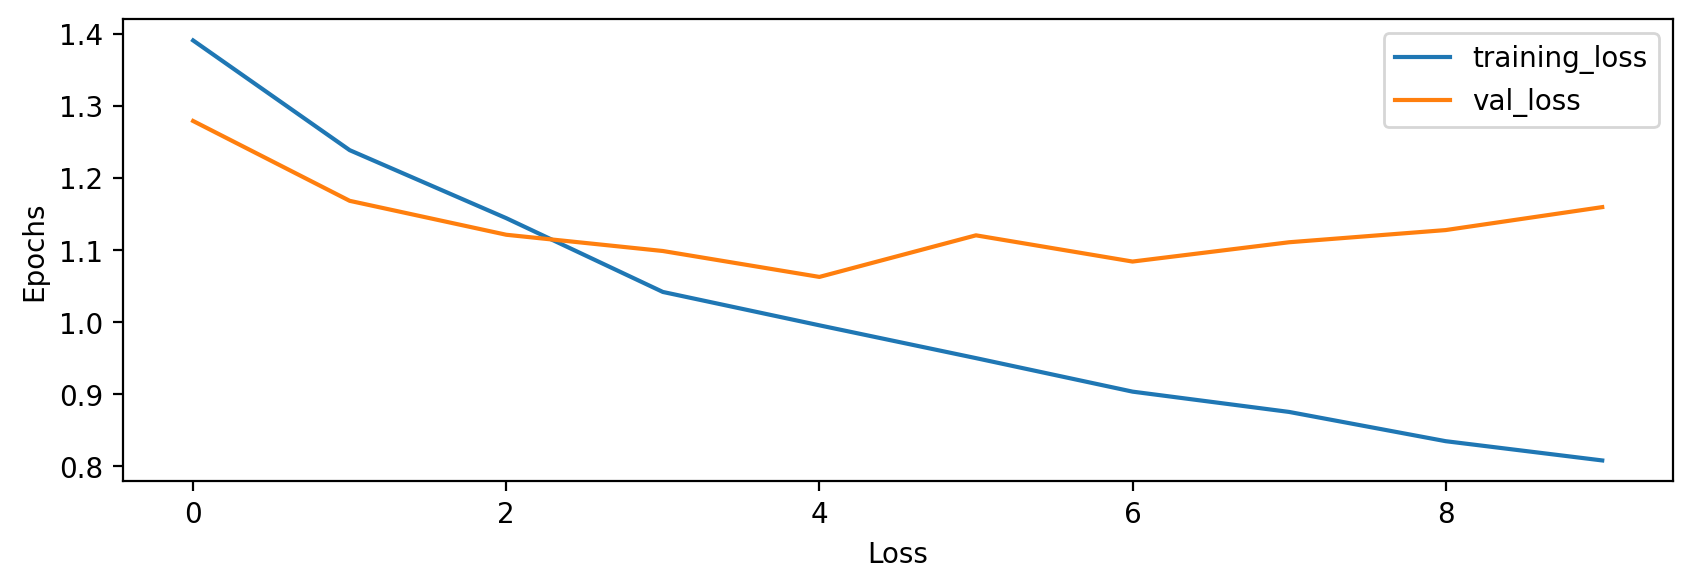

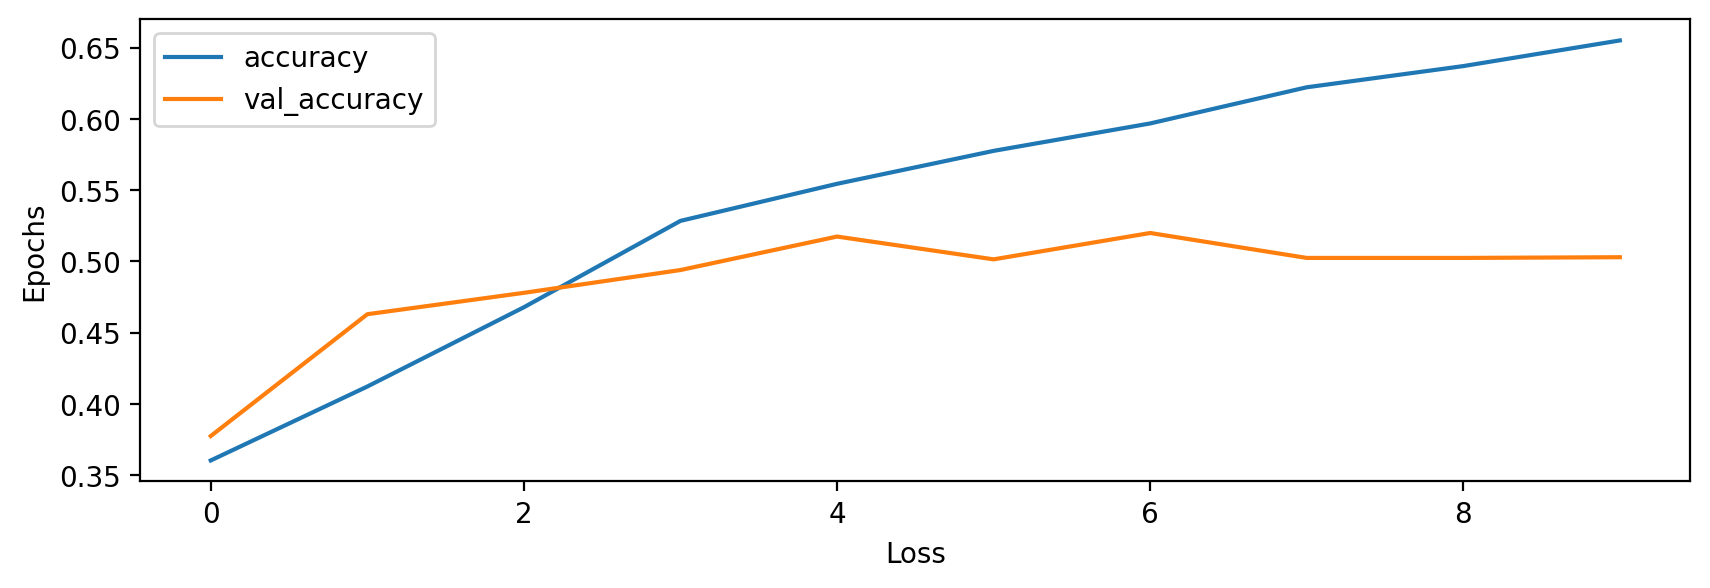

In [42]:
#plotting the losses

plt.figure(dpi=200, figsize = (10,3))
plt.plot(losses['loss'],
label='training_loss')
plt.plot(losses['val_loss'],
label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#plotting the accuracy
plt.figure(dpi=200, figsize = (10,3))
plt.plot(losses['accuracy'],
label='accuracy')
plt.plot(losses['val_accuracy'],
label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [43]:
rnn_model_accuracy = history.history['val_accuracy'][-1]
print(f"Accuracy Training data: {history.history['accuracy'][-1]}")
print(f"Accuracy Test data: {history.history['val_accuracy'][-1]}")
print(f"Training time: {training_time_rnn}")

Accuracy Training data: 0.6551250219345093
Accuracy Test data: 0.503000020980835
Training time: 330.85553


##### Using the BERT Language Model

In [44]:
# Renaming, Input -> X, Output -> y
X_bt = df['text']
y_bt = df['stars']

# Convert labels into a one-hot vector of size 5 (the number of distinct labels)
lab = LabelBinarizer()
lab.fit(y_bt)
y_bert = lab.transform(y_bt)

# Example (you can modify n)
n=100
print('Coding of labels into a one-hot vector: ' + str(y_bt[n]) + ' is ', y_bert[n])


Coding of labels into a one-hot vector: 4 is  [0 0 0 1 0]


In [45]:
# distil-bert tokenizer
tokenizer_bert = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
X_bt = [tokenizer_bert(text, padding='max_length', max_length = 512, truncation=True)['input_ids'] for text in X_bt]
X_bt = np.array(X_bt, dtype='int32')

In [46]:
# Train/test split
X_bert_train, X_bert_test, y_bert_train, y_bert_test = train_test_split(X_bt, y_bert, test_size=0.2, random_state=0, stratify=y_bt)
print('Shape of training data: ',X_bert_train.shape)

Shape of training data:  (8000, 512)


In [47]:
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
dbert = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config, trainable=False)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [48]:
# Let's create a sampe of size 5 from the training data
sample = X_bert_train[0:5]
print('Object type: ', type(dbert(sample)))
print('Output format (shape): ',dbert(sample)[0].shape)
print('Output used as input for the classifier (shape): ', dbert(sample)[0][:,0,:].shape)


Object type:  <class 'transformers.modeling_tf_outputs.TFBaseModelOutput'>
Output format (shape):  (5, 512, 768)
Output used as input for the classifier (shape):  (5, 768)


In [49]:
input_ids_in = layers.Input(shape=(512,), name='input_token', dtype='int32')

x = dbert(input_ids=input_ids_in)[0][:,0,:]
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
x = layers.Dense(5, activation='softmax', name='classification')(x)

dmodel = models.Model(inputs=input_ids_in, outputs = x)

dmodel.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
dmodel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 512)]             0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 512,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                           

In [50]:
# Train the model
start_time = datetime.now()
history = dmodel.fit(X_bert_train, y_bert_train, batch_size=128, shuffle=True, epochs=10, validation_data=(X_bert_test, y_bert_test))
end_time = datetime.now()

Epoch 1/10
63/63 [==============================] - 8953s 142s/step - loss: 1.4438 - accuracy: 0.3594 - val_loss: 1.4021 - val_accuracy: 0.3935
Epoch 2/10
63/63 [==============================] - 12635s 202s/step - loss: 1.4088 - accuracy: 0.3775 - val_loss: 1.3794 - val_accuracy: 0.4260
Epoch 3/10
63/63 [==============================] - 8564s 136s/step - loss: 1.3900 - accuracy: 0.3889 - val_loss: 1.3606 - val_accuracy: 0.3875
Epoch 4/10
63/63 [==============================] - 9030s 144s/step - loss: 1.3620 - accuracy: 0.3980 - val_loss: 1.3257 - val_accuracy: 0.4190
Epoch 5/10
63/63 [==============================] - 9161s 146s/step - loss: 1.3435 - accuracy: 0.4041 - val_loss: 1.3285 - val_accuracy: 0.3765
Epoch 6/10
63/63 [==============================] - 9078s 144s/step - loss: 1.3286 - accuracy: 0.4126 - val_loss: 1.2877 - val_accuracy: 0.4350
Epoch 7/10
63/63 [==============================] - 9065s 144s/step - loss: 1.3129 - accuracy: 0.4211 - val_loss: 1.2913 - val_accuracy

In [51]:
print(end_time)

2023-04-09 16:03:51.060369


In [59]:
training_time_bert = (end_time - start_time).total_seconds()
training_time_bert

98626.785053

In [52]:
# plotting the losses
losses =pd.DataFrame(history.history)
losses

,loss,accuracy,val_loss,val_accuracy
0,1.443776,0.359375,1.402062,0.3935
1,1.408789,0.377500,1.379355,0.4260
2,1.389952,0.388875,1.360611,0.3875
3,1.361954,0.398000,1.325701,0.4190
4,1.343502,0.404125,1.328527,0.3765
5,1.328637,0.412625,1.287745,0.4350
6,1.312865,0.421125,1.291348,0.4095
7,1.305686,0.424375,1.279390,0.4155
8,1.298278,0.428625,1.268304,0.4330
9,1.290272,0.434875,1.254837,0.4275


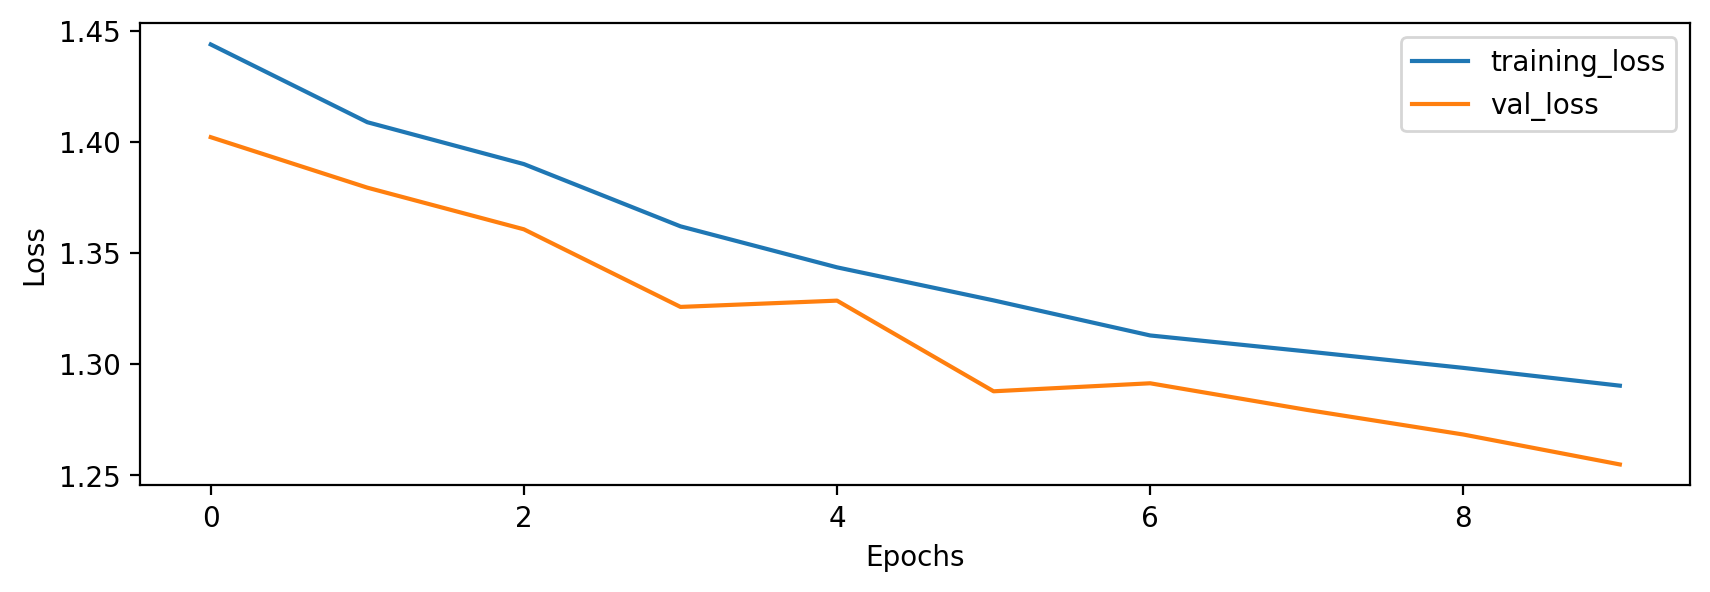

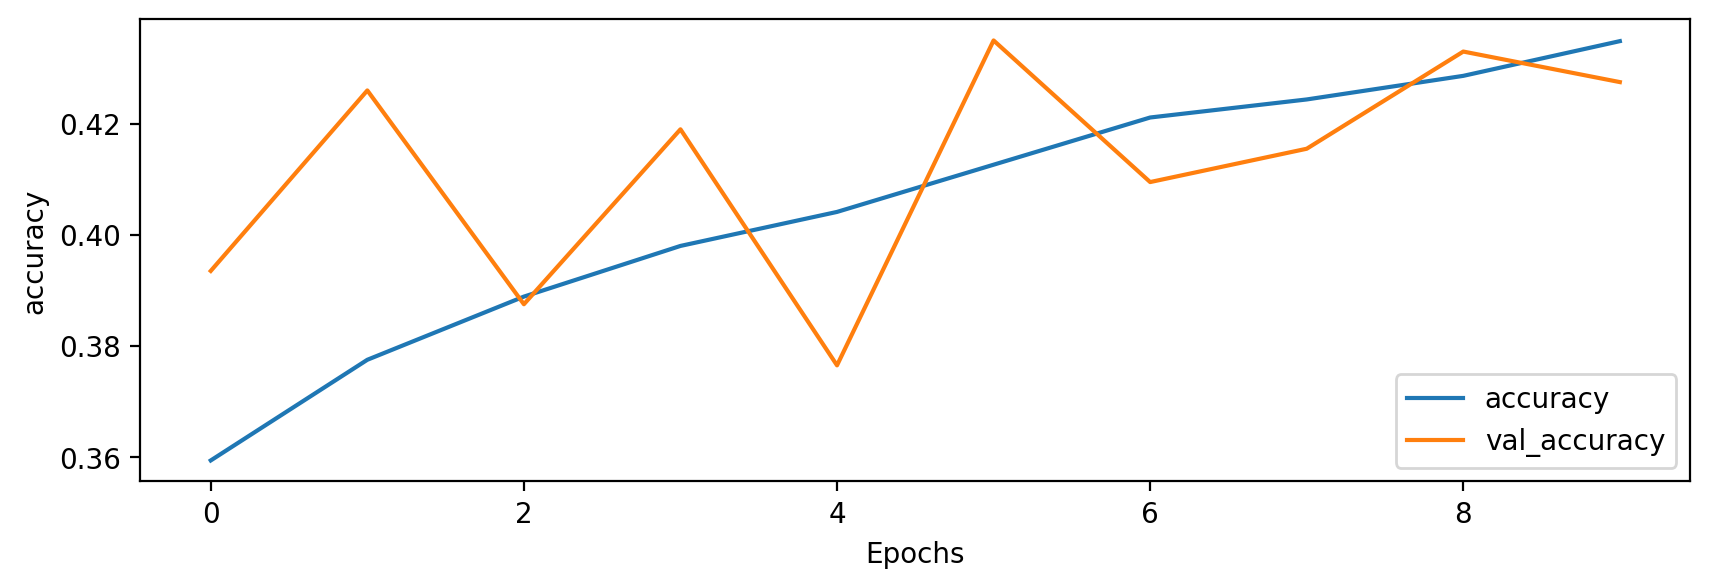

In [57]:
#plotting the losses

plt.figure(dpi=200, figsize = (10,3))
plt.plot(losses['loss'],
label='training_loss')
plt.plot(losses['val_loss'],
label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#plotting the accuracy
plt.figure(dpi=200, figsize = (10,3))
plt.plot(losses['accuracy'],
label='accuracy')
plt.plot(losses['val_accuracy'],
label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [54]:
bert_model_accuracy = history.history['val_accuracy'][-1]
print(f"Accuracy Training data: {history.history['accuracy'][-1]}")
print(f"Accuracy Test data: {history.history['val_accuracy'][-1]}")
print(f"Training time: {training_time_rnn}")

Accuracy Training data: 0.4348750114440918
Accuracy Test data: 0.42750000953674316
Training time: 330.85553


In [64]:
Model = ['L-R','TF-IDF', 'RNN', 'BERT']
accuracy = [0.982,acc_train_tfidf, rnn_model_accuracy, bert_model_accuracy]
accuracy = [str(round(acc*100, 1))+'%' for acc in accuracy]
training_time = [3.3,round(training_time_tfidf,1), round(training_time_rnn,1), round(training_time_bert,1)]
training_time_rounded = [round(tt,1) for tt in training_time]
training_time = np.array(training_time)
training_time_x = list(training_time /min(training_time))
training_time_x = [str(round(ttx,1))+'x' for ttx in training_time_x]

dict = {'Model' : Model,
        'Accuracy' : accuracy,
        'Training Time [s]' : training_time_rounded,
        'Training Time [x]' : training_time_x}
df = pd.DataFrame(dict)
display(df)

,Model,Accuracy,Training Time [s],Training Time [x]
0,L-R,98.2%,3.3,1.0x
1,TF-IDF,79.9%,4.3,1.3x
2,RNN,50.3%,330.9,100.3x
3,BERT,42.8%,98626.8,29886.9x


##### Part of the code ideas were gotten from https://github.com/feldges/Classification/blob/main/Classification.ipynb